# Feedforward Neural Networks
## An introduction to `torch.nn` and the required setup code

We're going to explain the concepts behind `torch.nn`, and go over the training process in PyTorch. 

## Project Setup

In [67]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors
import time

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook 

from IPython.display import HTML
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs

import torch
import torch.nn as nn
warnings.filterwarnings('ignore')

## Prepare Data

We would typically import a dataset externally, and PyTorch provides the useful Dataloader classes for this sort of thing. But for now we're going to just generate a dummy dataset using sklearn, and then test-train-split it. This is a one-time cross validation situation, and we'll look at k folds CV later

In [97]:
xs, ys = make_blobs(n_samples = 700, centers = 3, n_features=2)

In [98]:
print(xs[0]) # First sample, with 2 coordinates
print(ys[0]) # The label of the first sample

[1.2863554  0.65936056]
0


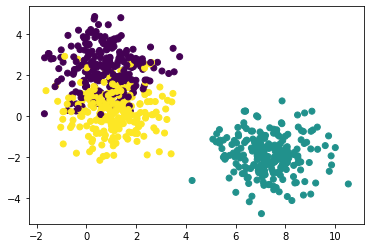

In [99]:
plt.scatter(xs[:,0],xs[:,1],c=ys)

In [100]:
X_train, x_val, Y_train, Y_val = train_test_split(xs, ys, stratify=ys)
X_train[0]

array([0.67444367, 2.37972705])

We need to convert our 2D numpy array into a PyTorch tensor

In [101]:

X_train, Y_train, X_val, Y_val = map(torch.tensor, (X_train, Y_train, X_val, Y_val))


## Defining the Model

All networks extend torch.nn.module

We define the architecture (layer types) in the constructor, and we define the linking in the model's `forward()` function


In [102]:
class Model(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.lin1 = nn.Linear(2, 2) # Input layer
        self.lin2 = nn.Linear(2, 3) # Output layer
    
    def forward(self, X):
        a1 = self.lin1(X) # Define lin1 acting on input X
        h1 = a1.sigmoid() # Transform lin1's activation with a sigmoid
        a2 = self.lin2(h1) # Pipeline the activation into lin2

        h2 = a2.exp()/a2.exp().sum(-1).unsqueeze(-1) # This is the softmax activation function
        return h2

In [103]:
model = Model()

## Training our Model

Torch comes with a bunch of optimisers which take the gradients from backward() and decide how to change each of the weights/biases (parameters) in the NN

We pass the model parameters to our optimiser, and the optimiser then handles all the logic to change the weights. Remember the weight tensors store the gradients in themselves.

In [104]:
epochs = 1000
learning_rate = 0.2

In [105]:
loss_fn = torch.nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=learning_rate)

We define a loss metric (cross entropy) and we define an optimiser (Stochastic Gradient Descent)

In [106]:
def accuracy(y_hat, y):
    pred = torch.argmax(y_hat, dim=1)
    return (pred == y).float().mean()

In [107]:
def train(x,y, epochs, opt, loss_fn):
    loss_arr = []
    acc_arr = []
    # We generalise for any opt or loss type, any input data, and epoch number
    for epoch in range(epochs):
        y_pred = model(x.float())
        loss = loss_fn(y_pred,y) # Get model performance
        loss.backward() # Annotate all parameters with their gradients
        loss_arr.append(loss.item())
        acc_arr.append(accuracy(y_pred, y))

        opt.step() # The optimiser
        opt.zero_grad()
        # Each epoch we start again. Opt is designed to store the total history of gradients (which is convenient in some architectures), but we're starting again and don't want to record previous epoch gradients, so wee start again with blank gradients.

    plt.plot(loss_arr, 'r-', label='loss')
    plt.plot(acc_arr, 'b-', label='train accuracy')
    plt.legend(loc='best')
    plt.title('title')
    plt.xlabel("Epoch")
    plt.show()      
    print('Loss before training', loss_arr[0])
    print('Loss after training', loss_arr[-1])

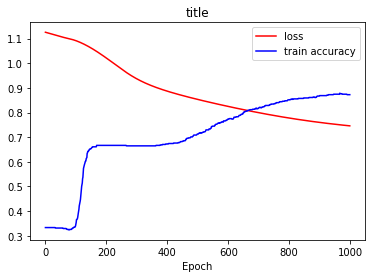

Loss before training 1.1255803108215332
Loss after training 0.7459363341331482


In [108]:
train(X_train,Y_train,epochs,opt,loss_fn)

---
### References

1. https://www.marktechpost.com/2019/06/30/building-a-feedforward-neural-network-using-pytorch-nn-module/
2. https://medium.com/biaslyai/pytorch-introduction-to-neural-network-feedforward-neural-network-model-e7231cff47cb
3. Ritchie Ng, Jie Fu. (2019, April 18). Deep Learning Wizard (Version v1.0.1). Zenodo. http://doi.org/10.5281/zenodo.2644957